<a href="https://colab.research.google.com/github/Mehrab-Shahbazi/human-object-detection/blob/main/Object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Requirement

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U openmim
!mim install mmengine
!mim install "mmcv>=2.0.0"
!mim install mmdet

Looking in links: https://download.openmmlab.com/mmcv/dist/cu121/torch2.1.0/index.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu121/torch2.1.0/index.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu121/torch2.1.0/index.html


In [ ]:
!pip install ultralytics
from ultralytics import YOLO

In [ ]:
!mim download mmdet --config faster-rcnn_r101_fpn_ms-3x_coco --dest .

processing faster-rcnn_r101_fpn_ms-3x_coco...
faster_rcnn_r101_fpn_mstrain_3x_coco_20210524_110822-4d4d2ca8.pth exists in /content
Successfully dumped faster-rcnn_r101_fpn_ms-3x_coco.py to /content


In [ ]:
!mim download mmdet --config retinanet_x101-64x4d_fpn_ms-640-800-3x_coco --dest .

processing retinanet_x101-64x4d_fpn_ms-640-800-3x_coco...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.6/366.6 MiB 11.5 MB/s eta 0:00:00
Successfully downloaded retinanet_x101_64x4d_fpn_mstrain_3x_coco_20210719_051838-022c2187.pth to /content
Successfully dumped retinanet_x101-64x4d_fpn_ms-640-800-3x_coco.py to /content


In [ ]:
import cv2
from PIL import Image, ImageDraw, ImageFont
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle
from mmdet.apis import DetInferencer
from mmdet.apis import init_detector, inference_detector

In [ ]:
!mkdir checkpoints
#download pretrained detector
!wget -c https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth \
      -O checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth

--2024-02-21 18:50:03--  https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 163.181.66.107, 163.181.66.106, 163.181.66.111, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|163.181.66.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177867103 (170M) [application/octet-stream]
Saving to: ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’

checkpoints/mask_rc 100%[===================>] 169.63M  9.36MB/s    in 19s     

2024-02-21 18:50:23 (9.14 MB/s) - ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’ saved [177867103/177867103]



##**YOLO**

In [ ]:
def extract_frames(path_videos, max_num_frames=1000):
    path_videos =  glob.glob(f'{path_videos}/*.mp4')
    num_frame = 0
    for path_video in sorted(path_videos):
        print("path_video", path_video)
        path_frames_video = path_video.split('/')[-1].replace(".mp4","")
        print("path_frames_video", path_frames_video)
        # path_frames_video = f"{path_frames}/{path_frames_video}"
        os.makedirs(path_frames_video, exist_ok=True)
        cap, i = cv2.VideoCapture(path_video), 0
        while i < max_num_frames:
          ret, frame = cap.read()
          if not ret: break
          frame_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
          yield frame_img
        num_frame += 1
        cap.release()
        print(f"number of extracted frames: {num_frame}")


path_video /content/drive/MyDrive/HiWeb_task/test.mp4
path_frames_video test


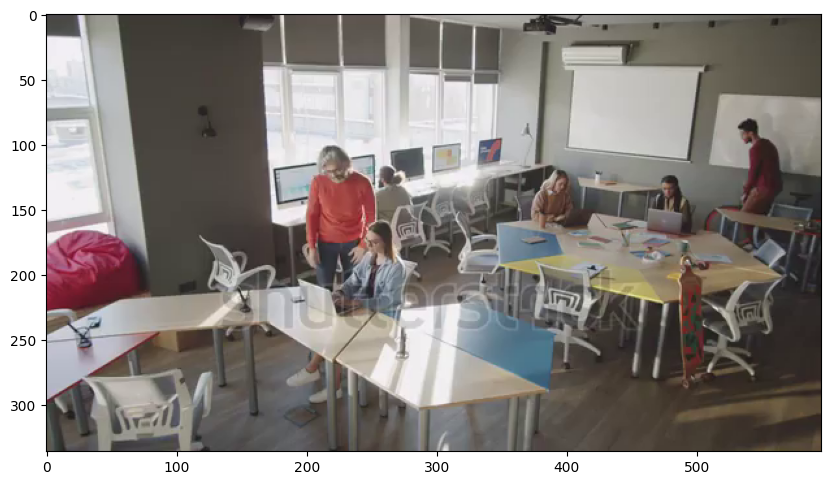

In [ ]:
path_video = "/content/drive/MyDrive/HiWeb_task"
plt.figure(figsize=(10, 8))
plt.imshow(next(extract_frames(path_video)))
plt.savefig("frame_testing.png")

In [ ]:
class ObjectDetector:
    def __init__(self, conf_threshold, train):

        self.conf_threshold = conf_threshold
        self.train = train

    def point_inside_polygon(self, x, y, poly):
        n = len(poly)
        inside = False
        p1x, p1y = poly[0]
        for i in range(1, n + 1):
            p2x, p2y = poly[i % n]
            if y > min(p1y, p2y):
                if y <= max(p1y, p2y):
                    if x <= max(p1x, p2x):
                        if p1y != p2y:
                            xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                        if p1x == p2x or x <= xinters:
                            inside = not inside
            p1x, p1y = p2x, p2y
        return inside

    def filter_boxes(self, results, polygon):
        conf_threshold = self.conf_threshold
        box_classes = results[0].boxes.cls.int().cpu().tolist()
        box_confs = results[0].boxes.conf.cpu().tolist()
        valid_boxes = [results[0].boxes.xyxy.int().cpu()[i] for i in range(len(results[0].boxes)) if box_classes[i] == 0 and box_confs[i] > conf_threshold]
        boxes_in_polygon = [box for box in valid_boxes if self.point_inside_polygon((box[0] + box[2]) / 2, (box[1] + box[3]) / 2, polygon)]
        return valid_boxes, boxes_in_polygon

    def draw_boxes_with_count(self, image, all_boxes, polygon_boxes, count_all, count_polygon):
        img_draw = Image.fromarray(image)
        draw = ImageDraw.Draw(img_draw)
        font = ImageFont.load_default()
        flattened_polygon = [coord for sublist in polygon for coord in sublist]
        draw.polygon(flattened_polygon, outline=(0, 255, 0), width=2)
        draw.text((10, 10), f"Number of people (Full Video): {count_all}", fill=(0, 0, 0), font=font)
        draw.text((10, 30), f"Number of people (Polygon Area): {count_polygon}", fill=(0, 0, 0), font=font)
        for box in all_boxes:
            x1, y1, x2, y2 = box
            draw.rectangle([x1, y1, x2, y2], outline=(0, 0, 255), width=2)
        for box in polygon_boxes:
            x1, y1, x2, y2 = box
            draw.rectangle([x1, y1, x2, y2], outline=(255, 0, 0), width=2)

        return np.array(img_draw)

    def inference_yolo(self, frame_path, output_video_path, polygon):
        frames = sorted(glob.glob(f"{frame_path}/*.png"))
        if self.train:
            model = YOLO('yolov8n.yaml')
            model = YOLO('yolov8n.pt')  # load a pretrained YOLOv8n detection model
            model.train(data='coco128.yaml', epochs=3)  # train the model
            success = model.export(format="onnx")
        else:
            model = YOLO("yolov5s.pt")

        first_frame = cv2.imread(frames[0])
        height, width, layers = first_frame.shape
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        video = cv2.VideoWriter(output_video_path, fourcc, 30.0, (width, height))
        count_all = 0
        count_polygon = 0
        for img in extract_frames(path_video):

            results = model.track(img, persist=True)
            all_boxes, polygon_boxes = self.filter_boxes(results, polygon)
            count_all = len(all_boxes)
            count_polygon = len(polygon_boxes)
            img_with_boxes = self.draw_boxes_with_count(np.array(img), all_boxes, polygon_boxes, count_all, count_polygon)
            img_with_boxes_bgr = cv2.cvtColor(img_with_boxes, cv2.COLOR_RGB2BGR)
            video.write(img_with_boxes_bgr)

        video.release()
        cv2.destroyAllWindows()
        print(f"Video saved at {output_video_path}")

# Example usage
path_frame = "/content/drive/MyDrive/HiWeb_task/test"
output_video_path = "/content/output_video.mp4"
polygon = [[250, 80], [380, 80], [380, 160], [250, 160]]
obj_detector = ObjectDetector(conf_threshold=0.3, train = False)
obj_detector.inference_yolo(path_frame, output_video_path, polygon)



PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 17.7M/17.7M [00:00<00:00, 104MB/s] 


path_video /content/drive/MyDrive/HiWeb_task/test.mp4
path_frames_video test
requirements: Ultralytics requirement ['lapx>=0.5.2'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.1 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 9.6s, installed 1 package: ['lapx>=0.5.2']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


0: 384x640 4 persons, 2 chairs, 1 laptop, 359.5ms
Speed: 3.9ms preprocess, 359.5ms inference, 17.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 chairs, 1 laptop, 287.2ms
Speed: 2.2ms preprocess, 287.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 chairs, 1 laptop, 279.0ms
Speed: 2.3ms preprocess, 279.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 2 chairs, 1 laptop, 291.2ms
Speed: 2.8ms preprocess, 291.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



##**MMDETECTION**

In [ ]:

class ObjectDetector:
    def __init__(self, conf_threshold, polygon):
        self.conf_threshold = conf_threshold
        self.polygon = polygon

    def point_inside_polygon(self, x, y, poly):
        n = len(poly)
        inside = False
        p1x, p1y = poly[0]
        for i in range(1, n + 1):
            p2x, p2y = poly[i % n]
            if y > min(p1y, p2y):
                if y <= max(p1y, p2y):
                    if x <= max(p1x, p2x):
                        if p1y != p2y:
                            xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                        if p1x == p2x or x <= xinters:
                            inside = not inside
            p1x, p1y = p2x, p2y
        return inside

    def filter_boxes(self, results, polygon):
        bboxes = results.pred_instances.bboxes
        labels = results.pred_instances.labels
        scores = results.pred_instances.scores

        valid_boxes = []
        for bbox, label, score in zip(bboxes, labels, scores):
            if label == 0 and score > self.conf_threshold:  # Assuming class ID for "person" is 0
                valid_boxes.append(bbox)

        boxes_in_polygon = [box for box in valid_boxes if self.point_inside_polygon((box[0] + box[2]) / 2, (box[1] + box[3]) / 2, polygon)]

        return valid_boxes, boxes_in_polygon

    def draw_boxes_with_count(self, image, all_boxes, polygon_boxes, count_all, count_polygon):
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display

        # Draw rectangles for all detected objects
        for bbox in all_boxes:
            xmin, ymin, xmax, ymax = map(int, bbox)
            cv2.rectangle(image_rgb, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)

        # Draw rectangles for objects inside the polygon
        for bbox in polygon_boxes:
            xmin, ymin, xmax, ymax = map(int, bbox)
            cv2.rectangle(image_rgb, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        # Draw rectangle around the polygon
        poly_pts = np.array(self.polygon, np.int32)
        poly_pts = poly_pts.reshape((-1, 1, 2))
        cv2.polylines(image_rgb, [poly_pts], True, (255, 0, 0), 2)

        # Add count information to the image
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image_rgb, f'Number of people (Full Video): {count_all}', (10, 20), font, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(image_rgb, f'Number of people (Polygon Area): {count_polygon}', (10, 40), font, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

        return image_rgb

    def inference_pretrained_model(self, frame_path, output_video_path):
        frames = sorted(glob.glob(f"{frame_path}/*.png"))

        # Load the first frame to get its size
        first_frame = cv2.imread(frames[0])
        height, width, _ = first_frame.shape

        # Define the codec and create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        video = cv2.VideoWriter(output_video_path, fourcc, 30.0, (width, height))

        config_file = '/content/retinanet_x101-64x4d_fpn_ms-640-800-3x_coco.py'
        checkpoint_file = '/content/retinanet_x101_64x4d_fpn_mstrain_3x_coco_20210719_051838-022c2187.pth'
        model = init_detector(config_file, checkpoint_file, device='cpu')  # or device='cuda:0'
        count_all = 0
        count_polygon = 0
        for frame_file in frames[:]:
            print("frame_file", frame_file)
            img = cv2.imread(frame_file)
            result = inference_detector(model, img)
            print("result", result)
            all_boxes, polygon_boxes = self.filter_boxes(result, self.polygon)
            count_all = len(all_boxes)
            count_polygon = len(polygon_boxes)
            img_with_boxes = self.draw_boxes_with_count(img, all_boxes, polygon_boxes, count_all, count_polygon)
            img_with_boxes_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
            video.write(img_with_boxes_rgb)

        video.release()
        print(f"Video saved at {output_video_path}")


# Example usage
path_frame = "/content/drive/MyDrive/HiWeb_task/test"
output_video_path = "/content/output_video.mp4"
polygon = [[250, 80], [380, 80], [380, 160], [250, 160]]
obj_detector = ObjectDetector(conf_threshold=0.57, polygon = polygon)
obj_detector.inference_pretrained_model(path_frame, output_video_path)


Streaming output truncated to the last 5000 lines.
                        [1.2913e+01, 1.9387e+02, 2.5503e+02, 2.8794e+02],
                        [2.0422e+02, 1.9601e+02, 2.9839e+02, 3.1633e+02],
                        [4.0110e+02, 1.3880e+02, 4.3225e+02, 1.6408e+02],
                        [2.0849e+02, 1.5673e+02, 2.5414e+02, 2.5142e+02],
                        [2.1534e+02, 1.5454e+02, 2.6410e+02, 2.1067e+02],
                        [2.8459e+02, 1.5085e+02, 5.8320e+02, 3.1111e+02],
                        [4.8846e-01, 1.6818e+02, 5.2699e+02, 3.2185e+02],
                        [4.4637e+02, 1.2766e+02, 4.7108e+02, 1.5390e+02],
                        [3.3602e+02, 1.4031e+02, 3.7525e+02, 2.0234e+02],
                        [4.4854e+00, 2.0833e+02, 1.7910e+02, 3.3600e+02],
                        [3.8912e+02, 1.9112e+02, 4.3110e+02, 2.4069e+02],
                        [5.2862e+02, 1.4871e+02, 5.9600e+02, 1.9336e+02],
                        [2.8416e+02, 1.2111e+02, 3.1621e+02, 